<a href="https://colab.research.google.com/github/huguette11/Administrator-dasboard/blob/main/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np  # Pour faire des calculs avec des nombres
import pandas as pd  # Pour créer des tableaux comme dans Excel

# Fixer le hasard pour avoir les mêmes résultats à chaque fois
np.random.seed(42)

# Nombre total de patients
nombre_patients = 10000

# Créer un tableau avec les patients
patients = pd.DataFrame({
    "Patient_ID": range(1, nombre_patients + 1),  # Numéros de 1 à 10 000
    "ESI_Level": np.random.choice([1, 2, 3, 4, 5], size=nombre_patients, p=[0.1, 0.2, 0.3, 0.25, 0.15]),  # Gravité
    "Bed_Needed": np.random.choice([0, 2], size=nombre_patients, p=[0.5, 0.5]),
    "ICU_Bed_Needed": np.where(np.random.rand(nombre_patients) < [0.9 if esi == 1 else 0.5 if esi == 2 else 0.1 for esi in np.random.choice([1, 2, 3, 4, 5], size=nombre_patients, p=[0.1, 0.2, 0.3, 0.25, 0.15])], 1, 0),  # Lit ICU
    "Generalist_Needed": np.random.choice([0, 1], size=nombre_patients, p=[0.4, 0.6]),  # Généraliste
    "Specialist_Needed": np.random.choice([0, 1], size=nombre_patients, p=[0.5, 0.5])  # Spécialiste
})

# Montrer les 5 premiers patients
print("Exemple de patients :")
print(patients.head())

# Prendre 80 % des patients pour l’entraînement
train_patients = patients.sample(frac=0.8, random_state=42)  # 8000 patients
test_patients = patients.drop(train_patients.index)  # Les 2000 restants

# Vérifier les tailles
print(f"Patients d’entraînement : {len(train_patients)}")
print(f"Patients de test : {len(test_patients)}")


# Nombre d’hôpitaux
nombre_hopitaux = 10

# Créer un tableau avec les hôpitaux
hopitaux = pd.DataFrame({
    "Hôpital": range(1, nombre_hopitaux + 1),  # Numéros de 1 à 10
    "Total_Beds": np.random.randint(500, 1200, size=nombre_hopitaux),  # Lits standards
    "Total_ICU_Beds": np.random.randint(50, 150, size=nombre_hopitaux),  # Lits ICU
    "Total_Generalists": np.random.randint(100, 250, size=nombre_hopitaux),  # Généralistes
    "Total_Specialists": np.random.randint(50, 200, size=nombre_hopitaux)  # Spécialistes
})

# Montrer les hôpitaux
print("\nHôpitaux :")
print(hopitaux)

Exemple de patients :
   Patient_ID  ESI_Level  Bed_Needed  ICU_Bed_Needed  Generalist_Needed  \
0           1          3         1.0               0                  1   
1           2          5         1.0               1                  1   
2           3          4         1.0               0                  1   
3           4          3         1.0               0                  0   
4           5          2         1.0               0                  1   

   Specialist_Needed  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
Patients d’entraînement : 8000
Patients de test : 2000

Hôpitaux :
   Hôpital  Total_Beds  Total_ICU_Beds  Total_Generalists  Total_Specialists
0        1         855              94                157                139
1        2        1035              69                199                153
2        3         717             108                222                198
3        4    

In [9]:
# Fonction qui dit si une répartition est bonne
def calculer_score(allocation, patients_data):
    # "allocation" = combien de patients ESI 1, 2, 3, 4, 5 dans chaque hôpital
    besoins_moyens = patients_data.groupby("ESI_Level").mean().values.T  # Moyenne des besoins par ESI

    # Combien de ressources sont utilisées ?
    lits = np.sum(allocation * besoins_moyens[0], axis=1)  # Lits standards (toujours 1)
    lits_icu = np.sum(allocation * besoins_moyens[1], axis=1)  # Lits ICU
    generalistes = np.sum(allocation * besoins_moyens[2], axis=1)  # Généralistes
    specialistes = np.sum(allocation * besoins_moyens[3], axis=1)  # Spécialistes

    # Problèmes : excédents ou manques
    lits_inutilises = np.maximum(0, hopitaux["Total_Beds"] - lits)  # Lits vides
    lits_icu_manquants = np.maximum(0, lits_icu - hopitaux["Total_ICU_Beds"])  # Pas assez d’ICU
    generalistes_manquants = np.maximum(0, generalistes - hopitaux["Total_Generalists"])  # Pas assez de généralistes
    specialistes_manquants = np.maximum(0, specialistes - hopitaux["Total_Specialists"])  # Pas assez de spécialistes

    # Score : somme des problèmes
    score = (sum(lits_inutilises) +
             100 * (sum(lits_icu_manquants) + sum(generalistes_manquants) + sum(specialistes_manquants)))

    # Vérifier 95 % d’allocation
    patients_places = np.sum(allocation)
    if patients_places < 0.95 * len(patients_data):
        score += 1000 * (0.95 * len(patients_data) - patients_places)

    return score

In [10]:
# Préparer PSO
n_particules = 20  # 20 idées différentes
n_dimensions = nombre_hopitaux * 5  # 10 hôpitaux x 5 ESI = 50 nombres à deviner
n_iterations = 100  # 50 essais

# Démarrer avec des idées aléatoires
particules = np.random.uniform(0, 1000, (n_particules, n_dimensions))  # Positions
vitesses = np.random.uniform(-50, 50, (n_particules, n_dimensions))  # Mouvements
meilleures_positions = particules.copy()  # Chaque idée garde son meilleur
meilleurs_scores = [calculer_score(p.reshape(nombre_hopitaux, 5), train_patients) for p in particules]
meilleure_position_globale = meilleures_positions[np.argmin(meilleurs_scores)].copy()
meilleur_score_global = min(meilleurs_scores)

# Boucle pour améliorer
for iteration in range(n_iterations):
    for i in range(n_particules):
        r1, r2 = np.random.rand(2)  # Deux nombres aléatoires
        vitesses[i] = (0.5 * vitesses[i] +  # Continuer un peu
                       2 * r1 * (meilleures_positions[i] - particules[i]) +  # Vers son meilleur
                       2 * r2 * (meilleure_position_globale - particules[i]))  # Vers le meilleur global
        particules[i] = np.maximum(particules[i] + vitesses[i], 0)  # Bouger, pas de négatif

        score = calculer_score(particules[i].reshape(nombre_hopitaux, 5), train_patients)
        if score < meilleurs_scores[i]:
            meilleurs_scores[i] = score
            meilleures_positions[i] = particules[i].copy()
            if score < meilleur_score_global:
                meilleur_score_global = score
                meilleure_position_globale = particules[i].copy()

    if iteration % 10 == 0:  # Montrer tous les 10 tours
        print(f"Iteration {iteration} : Meilleur score = {meilleur_score_global}")

# Montrer le résultat sur Train
allocation_train = meilleure_position_globale.reshape(nombre_hopitaux, 5)
resultat_train = pd.DataFrame(allocation_train, columns=["ESI_1", "ESI_2", "ESI_3", "ESI_4", "ESI_5"])
resultat_train["Hôpital"] = range(1, nombre_hopitaux + 1)
print("\nAllocation sur Train :")
print(resultat_train)
print(f"Score Train : {meilleur_score_global}")
print(f"Patients placés (Train) : {np.sum(allocation_train)} / {len(train_patients)}")

Iteration 0 : Meilleur score = 3316397.721372493
Iteration 10 : Meilleur score = 1130530.2112956636
Iteration 20 : Meilleur score = 1120936.6094237121
Iteration 30 : Meilleur score = 1119621.0041460607
Iteration 40 : Meilleur score = 1119129.7205049046
Iteration 50 : Meilleur score = 1114253.5784663002
Iteration 60 : Meilleur score = 1108866.5543792862
Iteration 70 : Meilleur score = 1107431.6858010425
Iteration 80 : Meilleur score = 1106320.576865937
Iteration 90 : Meilleur score = 1105975.46488348

Allocation sur Train :
        ESI_1       ESI_2      ESI_3       ESI_4        ESI_5  Hôpital
0    0.000000  514.277073   0.000000   83.380631     0.000000        1
1    0.000000    0.000000   0.000000    0.000000  1304.333032        2
2    0.000000    6.645163  10.453270    0.000000     0.000000        3
3    0.000000  562.903835   0.000000    0.000000     0.000000        4
4   13.844977    0.000000   0.000000  736.110137   561.273941        5
5    6.448338   77.111681   0.000000    0.414

In [11]:
# Étape 7 : Tester sur Test
# Calculer la proportion Test par rapport à Train
proportion_test = len(test_patients) / len(train_patients)  # 2000 / 8000 = 0.25

# Ajuster l’allocation pour Test
allocation_test = allocation_train * proportion_test  # Réduire pour correspondre à 2000 patients

# Calculer le score avec cette allocation ajustée
score_test = calculer_score(allocation_test, test_patients)

# Afficher les résultats
print("\nScore Test : ", score_test)
print(f"Patients placés (Test) : {np.sum(allocation_test)} / {len(test_patients)}")


Score Test :  169703.7915326077
Patients placés (Test) : 1900.0029025759789 / 2000


<ipython-input-14-c9ebb5bcfd49>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_patients["ESI_Level"], palette="coolwarm")


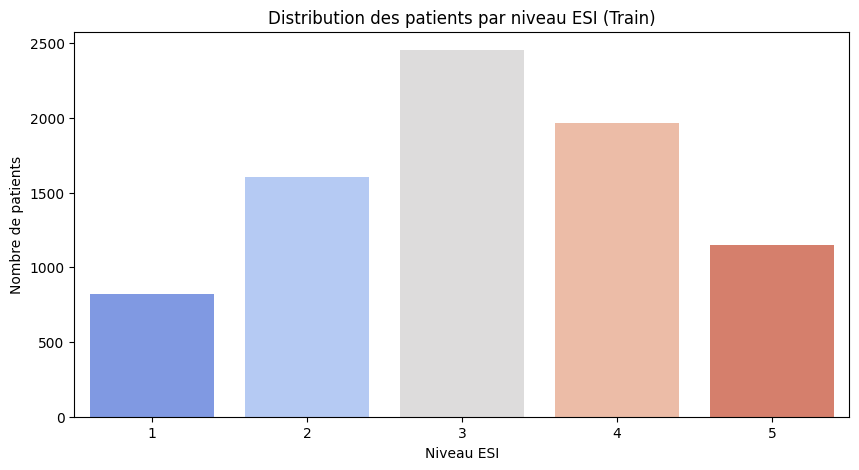

<ipython-input-14-c9ebb5bcfd49>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Hôpital", y="Total_Patients", data=resultat_train, palette="viridis")


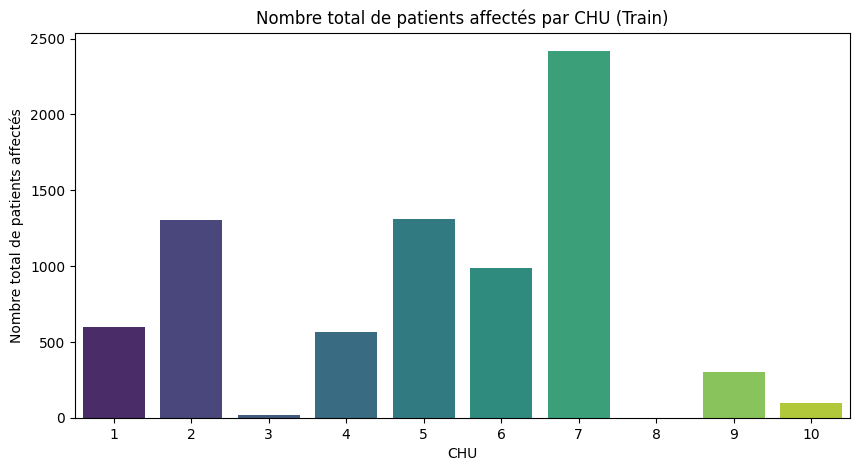

<Figure size 1200x600 with 0 Axes>

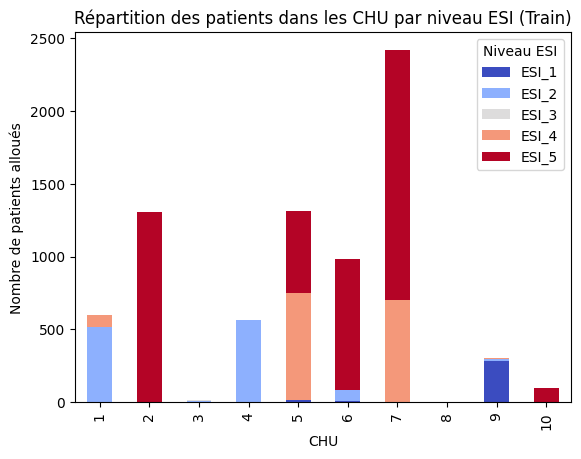

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(x=train_patients["ESI_Level"], palette="coolwarm")
plt.xlabel("Niveau ESI")
plt.ylabel("Nombre de patients")
plt.title("Distribution des patients par niveau ESI (Train)")
plt.show()

# 2. Nombre total de patients affectés par CHU (Train)
plt.figure(figsize=(10, 5))
resultat_train["Total_Patients"] = resultat_train[["ESI_1", "ESI_2", "ESI_3", "ESI_4", "ESI_5"]].sum(axis=1)
sns.barplot(x="Hôpital", y="Total_Patients", data=resultat_train, palette="viridis")
plt.xlabel("CHU")
plt.ylabel("Nombre total de patients affectés")
plt.title("Nombre total de patients affectés par CHU (Train)")
plt.show()

# 3. Répartition des patients par ESI dans chaque CHU (Train)
plt.figure(figsize=(12, 6))
resultat_train.set_index("Hôpital")[["ESI_1", "ESI_2", "ESI_3", "ESI_4", "ESI_5"]].plot(kind="bar", stacked=True, colormap="coolwarm")
plt.xlabel("CHU")
plt.ylabel("Nombre de patients alloués")
plt.title("Répartition des patients dans les CHU par niveau ESI (Train)")
plt.legend(title="Niveau ESI")
plt.show()